In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from foundry.util.runtime import setup
setup()
import jax
print("Devices:", jax.devices())

from image_diffusion.main import logger
logger.setLevel('INFO')

Devices: [CpuDevice(id=0)]


In [3]:
import foundry.random
import foundry.core.tree as tree
import foundry.numpy as npx
import foundry.train
from foundry.core.dataclasses import dataclass

import foundry.core as F
import flax.linen as nn
import flax.linen.activation as activations

import rich
import jax
import optax
import foundry.train.console

import matplotlib.pyplot as plt
from typing import Sequence

In [4]:
color_map = {
    0: "#E52B50",
    1: "#9F2B68",
    2: "#3B7A57",
    3: "#3DDC84",
    4: "#FFBF00",
    5: "#915C83",
    6: "#008000",
    7: "#7FFFD4",
    8: "#E9D66B",
    9: "#007FFF",
}
def embed_scatter(zs, labels, **kwargs):
    colors = [color_map[label.item()] for label in labels]
    plt.scatter(zs[:, 0], zs[:, 1], c=colors, **kwargs)

In [5]:
import wandb
api = wandb.Api()
artifact = api.artifact("dpfrommer-projects/image-diffusion/mnist-ddpm:v13")
checkpoint_url = artifact.get_entry("checkpoint.zarr.zip").ref
import foundry.util.serialize
checkpoint = foundry.util.serialize.load(checkpoint_url)

In [ ]:
import jax
model = checkpoint.config.create()
schedule = checkpoint.schedule
vars = checkpoint.vars
normalizer, train_data, test_data = checkpoint.create_data()
train_data = jax.vmap(normalizer.normalize)(train_data.as_pytree())
test_data = jax.vmap(normalizer.normalize)(test_data.as_pytree())

[13:39:22] INFO     image_diffusion - Learning T-SNE embedding...
[13:39:23] INFO     image_diffusion - Fit T-SNE embedding


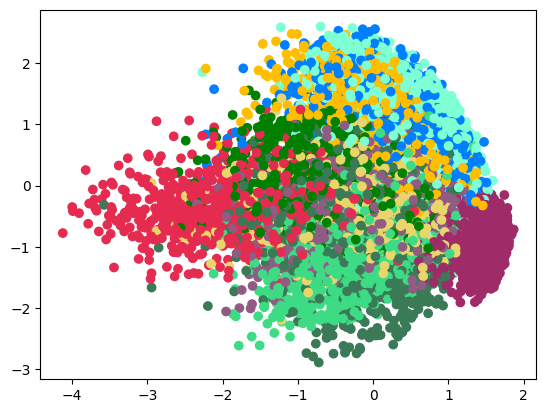

In [ ]:
if checkpoint.config.condition_type == "tsne":
    latents = test_data.cond
    encode = lambda x: x
    decode = lambda x: x
else:
    from latent_embed import train_embedding
    latents, encode, decode = train_embedding(
        test_data.cond, mode="tsne", 
        iterations=10_000
    )
embed_scatter(latents, test_data.label)

In [ ]:
if checkpoint.config.condition_type == "image":
    from foundry.train.reporting import Image

    X, Y = npx.meshgrid(
        npx.linspace(-3, 3, 32),
        npx.linspace(-3, 3, 32)[::-1],
    )
    Z = npx.stack((X,Y), axis=-1)
    # (row, col, height, width, channel)
    images = F.vmap(F.vmap(decode))(Z)
    # (row, height, col, width, channel)
    images = npx.permute_dims(images, (0, 2, 1, 3, 4))
    Image(images.reshape((images.shape[0]*images.shape[1], images.shape[2]*images.shape[3], 1)))

In [ ]:
import foundry.diffusion.nonparametric as nonparametric
import functools

@dataclass
class EvalSample:
    cond: jax.Array
    x_noised: jax.Array
    t: jax.Array
    out_model: jax.Array
    out_nw: jax.Array
    err: jax.Array

@F.jit
def eval(vars, rng_key):
    cond = jax.random.uniform(rng_key, (2,), minval=-3, maxval=3)
    def denoiser(rng_key, x, t):
        return model.apply(vars, x, t, cond=cond)
    sample = lambda rng: schedule.sample(rng, denoiser, npx.zeros(test_data.data[0].shape))

    samples_rng, ref_rng = foundry.random.split(rng_key)
    ref_sample = sample(ref_rng)
    # sample 16 times from the trained model at this conditioning location
    samples = jax.vmap(sample)(foundry.random.split(samples_rng, 16))

    # noise the reference sample to some level
    t = jax.random.randint(rng_key, (), 1, schedule.num_steps)
    # t = npx.array(schedule.num_steps // 2)
    x_noised, _, _ = schedule.add_noise(rng_key, ref_sample, t)
    out_nw = schedule.output_from_denoised(
        x_noised, t,
        schedule.compute_denoised(
            x_noised, t, samples
    ))
    out_model = model.apply(vars, x_noised, t, cond=cond)
    # x_model = schedule.denoised_from_output(
    #     x_noised, t,
    #     model.apply(vars, x_noised, t, cond=cond)
    # )
    err = npx.mean(npx.square(out_model - out_nw))
    return EvalSample(
        cond=cond,
        x_noised=x_noised, t=t,
        out_model=out_model, out_nw=out_nw,
        err=err
    )

eval_batch = functools.partial(
    F.vmap(eval, in_axes=(None, 0)),
    vars
)

eval_samples = []
logger.info("Evaluating error at samples")
r = foundry.random.PRNGSequence(42)
for i in rich.progress.track(range(16)):
    batch = eval_batch(
        foundry.random.split(next(r),128),
    )
    eval_samples.append(batch)
eval_samples : EvalSample = tree.map(lambda *x: npx.concatenate(x, 0), *eval_samples)

[17:40:38] INFO     image_diffusion - Evaluating error at samples


Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--


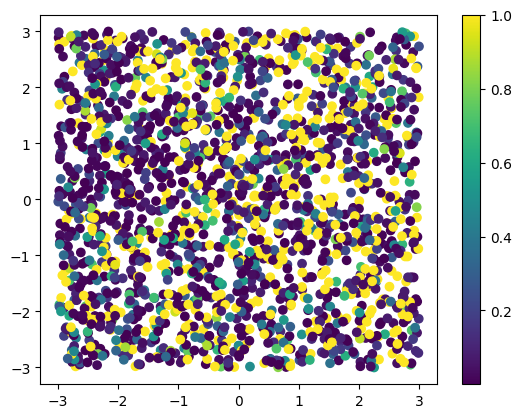

In [ ]:
plt.scatter(eval_samples.cond[:,0], eval_samples.cond[:,1], c=npx.clip(eval_samples.err, 0, 1))
plt.colorbar()

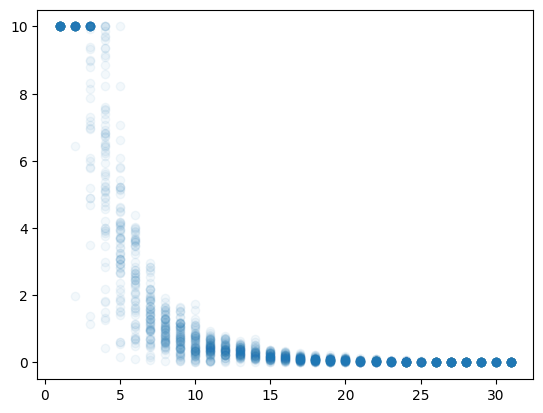

In [ ]:
plt.scatter(eval_samples.t, eval_samples.err.clip(0,10), alpha=0.1)

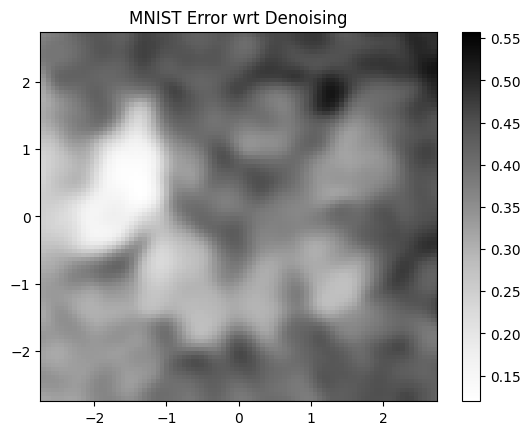

In [ ]:
xi = npx.linspace(-3,  3, 100)
yi = npx.linspace(-3, 3, 100)
def smooth(x, y):
    z = npx.stack((x,y), axis=-1)
    log_weights = -20*npx.sum(npx.square(z - eval_samples.cond), axis=-1)
    log_norm = jax.scipy.special.logsumexp(log_weights)
    log_weights = log_weights - log_norm
    weights = npx.exp(log_weights)
    err = npx.clip(npx.sqrt(eval_samples.err), 0, 1)
    return npx.sum(weights * err)
zi = jax.vmap(jax.vmap(smooth))(*npx.meshgrid(xi, yi))
plt.pcolormesh(xi, yi, zi, cmap="Greys")

plt.ylim(-2.75, 2.75)
plt.xlim(-2.75, 2.75)
plt.colorbar()
plt.title("MNIST Error wrt Denoising")
embed_scatter(latents, test_data.label, alpha=0.03)

In [ ]:
# Now we do the actual linearity test
# using 32 keypointss
keypoints = train_data.cond[:32]